In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
%matplotlib inline

In [2]:
loan = pd.read_csv(os.getcwd() + '\\data\\train_loanpred.csv')
tree_loan_cols = ['Gender', 'Married', 'Education',
                  'Self_Employed','ApplicantIncome', 'LoanAmount','Property_Area', 'Loan_Status']
tree_loan = loan[tree_loan_cols]
tree_loan.isnull().sum().sort_values(ascending=False)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(np.array(tree_loan.loc[:, 'LoanAmount']).reshape(-1,1))
tree_loan.loc[:,'LoanAmount'] = imputer.transform(np.array(tree_loan.loc[:, 'LoanAmount']).reshape(-1,1))
imputer_clf = SimpleImputer(strategy='most_frequent')
clf_imputer = imputer_clf.fit_transform(tree_loan.drop(columns=['LoanAmount', 'ApplicantIncome'], axis=1))
tree_loan.loc[:, 'Gender'] = clf_imputer[:,0]
tree_loan.loc[:,'Married'] = clf_imputer[:,1]
tree_loan.loc[:,'Education'] = clf_imputer[:,2]
tree_loan.loc[:,'Self_Employed'] = clf_imputer[:,3]
tree_loan.loc[:,'Property_Area'] = clf_imputer[:,4]
tree_loan.loc[:,'Loan_Status'] = clf_imputer[:,5]
X = tree_loan.iloc[:, :7]
Y = tree_loan.iloc[:, 7]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=22)
x_cat= pd.get_dummies(x_train, drop_first=True)
x_test_cat = pd.get_dummies(x_test, drop_first=True)
print(x_cat.shape)
x_cat.head()

(429, 8)


c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ApplicantIncome,LoanAmount,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
278,14583,436.0,1,1,0,0,1,0
507,3583,96.0,1,0,0,0,0,1
430,8624,150.0,0,0,0,1,1,0
58,8080,180.0,1,1,0,0,0,1
538,2917,66.0,1,1,1,0,0,0


In [15]:
#cross validation
model = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=3, criterion='gini')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, x_cat, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.674 (0.012)


In [113]:
rf = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=3, criterion='entropy', oob_score=True) 
#max_features=none,log2,auto
rf.fit(x_cat, y_train)
print("RF Training score: ", rf.score(x_cat, y_train))
print("RF OOB score: ", rf.oob_score_)
pred_rf = rf.predict(x_test_cat)
print("RF Accuracy score: ", accuracy_score(y_test, pred_rf))

RF Training score:  0.675990675990676
RF OOB score:  0.675990675990676
RF Accuracy score:  0.7189189189189189


[0.22221045 0.29845394 0.04393216 0.16779183 0.02980813 0.04146279
 0.12050869 0.075832  ]


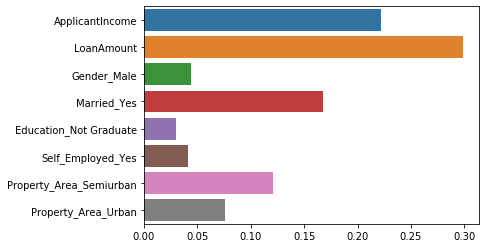

In [4]:
#Feature importances
print(rf.feature_importances_)
sns.barplot(rf.feature_importances_, x_cat.columns)

In [5]:
# Stats about the trees in random forest
n_nodes = []
max_depths = []
for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13
Average maximum depth 3


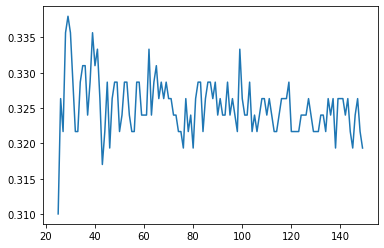

In [137]:
#oob error
from collections import OrderedDict 
err = OrderedDict()
err_val = []
rf1 = RandomForestClassifier(max_features='sqrt', max_depth=3, criterion='gini', oob_score=True)
for i in range(25,150):
    rf1.set_params(n_estimators=i)
    rf1.fit(x_cat, y_train)
    oob_error = 1 - rf1.oob_score_
    err[i] = oob_error
    err_val.append((i, oob_error))

xs, ys = zip(*err_val)
plt.plot(xs,ys)

In [107]:
#Cross validations
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
x10 = X.head(10)
y10 = Y.head(10)
for train_index, test_index in kf.split(x10, y10):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 4 5 6 7 8 9] TEST: [2 3]
TRAIN: [0 1 2 3 6 7 8 9] TEST: [4 5]
TRAIN: [0 1 2 3 4 5 8 9] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]


In [109]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)
y10 = Y.head(10)
groups = np.array([1,2,2,3,3,4,10,5,7,6])
for train_index, test_index in gkf.split(x10, y10, groups):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [0 1 2 5 6 7 8 9] TEST: [3 4]
TRAIN: [0 3 4 5 6 7 8 9] TEST: [1 2]
TRAIN: [0 1 2 3 4 5 8 9] TEST: [6 7]
TRAIN: [0 1 2 3 4 6 7 9] TEST: [5 8]
TRAIN: [1 2 3 4 5 6 7 8] TEST: [0 9]


In [122]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
for train_index, test_index in loo.split(x10, y10):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
